# Setup

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [11]:
fp = r"~\Documents\Hertie School\22_Machine-Learning\hertie-ml-x-project\2_Cleaned_Data\22_Files\ratings_clean_small.csv"
data = pd.read_csv(fp)

# Feature Selection

The following columns are not binary so you need the `get_dummies` function:
> Ask drew if we keep time (i.e. milliseconds) and what we do with identifiers (like Ids)

**To use function on**
classification
~~helpfulnessLevel~~
enrollmentState
modelingPopulation


**To drop for ML training**
'noteId', 'raterParticipantId', 'createdAtMillis_x', 'participantId', 'timestampOfLastStateChange', 'timestampOfLastEarnOut', 'ratedOnTweetId', 'noteAuthorParticipantId', 'createdAtMillis_y', 'tweetId', helpfulnessLevel (removed because of selection bias)

**Idk category**
successfulRatingNeededToEarnIn, modelingGroup, numberOfTimesEarnedOut



## Pre-process

In [12]:
df = data.drop(['noteId', 'raterParticipantId', 'createdAtMillis_x', 'participantId',
                'timestampOfLastStateChange', 'timestampOfLastEarnOut', 'ratedOnTweetId',
                'noteAuthorParticipantId', 'createdAtMillis_y', 'tweetId', 'helpfulnessLevel'], axis = 1)

In [13]:
df = pd.get_dummies(df, columns=['classification',
                                 'enrollmentState', 'modelingPopulation'], drop_first=True)

In [14]:
df.iloc[:, 40:50].head()

,modelingPopulation_EXPANSION,modelingPopulation_EXPANSION_PLUS
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


## Spliting Data 

In [15]:
X = df.drop('notHelpfulSpamHarassmentOrAbuse', axis = 1)

y = df['notHelpfulSpamHarassmentOrAbuse']

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initial XGBoost Model Training
Since we are doing classification, we will stick with XGBClassifier.

In [18]:
# Initialize and train the XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

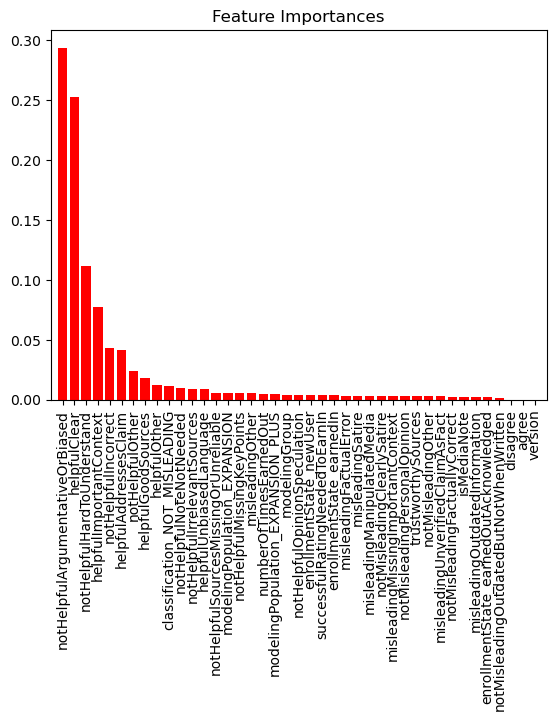

In [19]:
# Get and plot feature importances from the model
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [20]:
# Initialize a list to store the average cross-validation scores for different numbers of top features
cv_scores = []

# Iterate over the range of number of features, starting from 1 to the total number of features
for i in range(1, len(indices) + 1):
    # Select the top 'i' features
    top_features = [X_train.columns[indices[j]] for j in range(i)]
    
    # Create the training data using the selected features
    X_train_top = X_train_scaled[:, indices[:i]]
    
    # Initialize the model with the best parameters
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Perform cross-validation and store the mean score
    scores = cross_val_score(model, X_train_top, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the number of features that resulted in the highest mean CV score
optimal_features = np.argmax(cv_scores) + 1  # Adding 1 because list indices start at 0
optimal_score = cv_scores[optimal_features - 1]

print(f"Optimal number of features: {optimal_features}")
print(f"Highest CV accuracy: {optimal_score:.2f}%")



Optimal number of features: 23
Highest CV accuracy: 0.97%


In [21]:
## TO DO: Check how many 1s and 0s are in output variable (y). See if it is imbalanced becich will affect accuracy. 